In [ ]:
!pip install ultralytics
!pip install mediapipe

In [ ]:
import cv2
import numpy as np
from ultralytics import YOLO
import matplotlib.pyplot as plt

# FOR MEDIAPIPE 
import mediapipe as mp

In [ ]:
#MEDIAPIPE PART
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_pose = mp.solutions.pose

In [ ]:
model = YOLO('yolov8x-seg.pt')
#model.to('cuda') #uncomment this if cuda is available

In [ ]:
data = {
    "NOSE":[],
    "LEFT_EYE_INNER":[],
    "LEFT_EYE":[],
    "LEFT_EYE_OUTER":[],
    "RIGHT_EYE_INNER":[],
    "RIGHT_EYE":[],
    "RIGHT_EYE_OUTER":[],
    "LEFT_EAR":[],
    "RIGHT_EAR":[],
    "MOUTH_LEFT":[],
    "MOUTH_RIGHT":[],
    "LEFT_SHOULDER":[],
    "RIGHT_SHOULDER":[],
    "LEFT_ELBOW":[],
    "RIGHT_ELBOW":[],
    "LEFT_WRIST":[],
    "RIGHT_WRIST":[],
    "LEFT_PINKY":[],
    "RIGHT_PINKY":[],
    "LEFT_INDEX":[],
    "RIGHT_INDEX":[],
    "LEFT_THUMB":[],
    "RIGHT_THUMB":[],
    "LEFT_HIP":[],
    "RIGHT_HIP":[],
    "LEFT_KNEE":[],
    "RIGHT_KNEE":[],
    "LEFT_ANKLE":[],
    "RIGHT_ANKLE":[],
    "LEFT_HEEL":[],
    "RIGHT_HEEL":[],
    "LEFT_FOOT_INDEX":[],
    "RIGHT_FOOT_INDEX":[]
}
#MEDIAPIPE LANDMARKS DRAWING
file = '/content/c_normal.jpg'
image = cv2.imread(file)
BG_COLOR = (192, 192, 192) # gray
with mp_pose.Pose(
    static_image_mode=True,
    model_complexity=2,
    enable_segmentation=True,
    min_detection_confidence=0.5) as pose:
  image_height, image_width, _ = image.shape
  # Convert the BGR image to RGB before processing.
  results = pose.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
  #Store the data
  for key,i in zip(data.keys(), range(33)):
    data[key].append([results.pose_landmarks.landmark[i].x, results.pose_landmarks.landmark[i].y, results.pose_landmarks.landmark[i].z])
  # Draw pose landmarks on the image.
  """
  mp_drawing.draw_landmarks(
      image,
      results.pose_landmarks,
      mp_pose.POSE_CONNECTIONS,
      landmark_drawing_spec=mp_drawing_styles.get_default_pose_landmarks_style())
  """
for key in data.keys():
  data[key] = np.array(data[key])  

In [212]:
#Segmentation, this function receives a single image per use, the image must be a numpy matrix 
#this function returns a mask of the segmentated person or returns 0 if not persons were found

def yoloseg(img):
  #Get model results
  results = model(img)
  results = results[0]
  clases = results.boxes.cls.cpu().numpy().astype(int)
  #Find person index mask
  person = 0
  index = np.where(clases == person)[0]
  if np.size(index) == 0:
    #No persons were found
    return 0
  #return person mask as numpy array where mask is set to 1
  return results.masks.data.cpu().numpy()[index[0]].astype(int)

res = yoloseg(image)


0: 640x544 1 person, 3850.6ms
Speed: 3.2ms preprocess, 3850.6ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)


In [208]:

height, width = res.shape
x=0
y=1
z=2

if data["RIGHT_SHOULDER"][0,x] < data["RIGHT_EAR"][0,x]:
  #Get bounding box
  x1 = int(data["RIGHT_SHOULDER"][0,x]*width)
  y1 = int(data["RIGHT_SHOULDER"][0,y]*height)
  while res[y1,x1]:
    x1-=1

  bbox1 = (x1-60, y1+60)
  bbox2 = (int(data["RIGHT_SHOULDER"][0,x]*width), int(data["RIGHT_EAR"][0,y]*height))

  # Draw the rectangle on an image
  im = np.empty((height, width, 3))
  im[:,:,0] = res*255
  im[:,:,1] = res*255
  im[:,:,2] = res*255
  cv2.rectangle(im, bbox1, bbox2, (0, 255, 0), 2)
  crop = res[bbox2[1]:bbox1[1], bbox1[0]:bbox2[0]]

else:
  #Get bounding box
  x1 = int(data["LEFT_SHOULDER"][0,x]*width)
  y1 = int(data["LEFT_SHOULDER"][0,y]*height)
  while res[y1,x1]:
    x1+=1

  bbox1 = (x1+60, y1+60)
  bbox2 = (int(data["LEFT_SHOULDER"][0,x]*width), int(data["LEFT_EAR"][0,y]*height))

  # Draw the rectangle on an image
  im = np.empty((height, width, 3))
  im[:,:,0] = res*255
  im[:,:,1] = res*255
  im[:,:,2] = res*255
  cv2.rectangle(im, bbox1, bbox2, (0, 255, 0), 2)
  crop = res[bbox2[1]:bbox1[1], bbox2[0]:bbox1[0]]
  



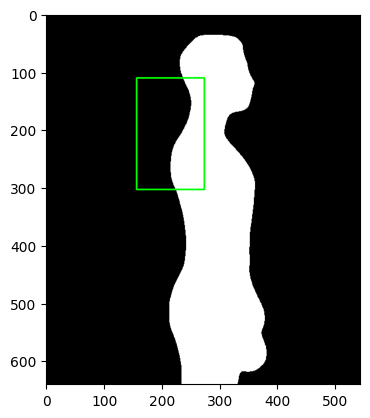

In [210]:
plt.imshow(im)

In [211]:
# Contar los píxeles con valor 1 (blanco)
area_1 = np.count_nonzero(crop == 1)

# Contar los píxeles con valor 0 (negro)
area_0 = np.count_nonzero(crop == 0)

# Calcular el área total de la imagen
area_total = area_1 + area_0

print("Área de los píxeles con valor 1 (blanco):", area_1)
print("Área de los píxeles con valor 0 (negro):", area_0)
print("Área total de la imagen:", area_total)
print("Área ocupada: " + str(round((area_1/area_total)*100, 2)) + '%')


Área de los píxeles con valor 1 (blanco): 7884
Área de los píxeles con valor 0 (negro): 14697
Área total de la imagen: 22581
Área ocupada: 34.91%
